<a href="https://colab.research.google.com/github/nee-no/mmWave/blob/master/CNN_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import math
import tensorflow as tf
import random
import copy
import os

def get_valid_data(mode): 
    in_folder = os.path.join("/content/drive/My Drive/Colab Notebooks/data")
    
    if (mode=="train"):
        x = np.load(os.path.join(in_folder, "X_train.npy"))
        y = np.load(os.path.join(in_folder, "Y_train.npy"))
        
    elif (mode=="test"):
        x = np.load(os.path.join(in_folder, "X_test.npy"))
        y = np.load(os.path.join(in_folder, "Y_test.npy"))
        
    else:
        x = np.load(os.path.join(in_folder, "X_valid.npy"))
        y = np.load(os.path.join(in_folder, "Y_valid.npy"))
    print(x.shape, y.shape)
    return x, y

# define train, test, validation ratio and split data
X, y = get_valid_data(mode="train")
X_train = X[:, 0:30, :, :, :]
y_train = y[:, 0:30, :]
X_valid = X[:, 30:35, :, :, :]
y_valid = y[:, 30:35, :]
X_test = X[:, 35:, :, :, :]
y_test = y[:, 35:,:]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(863, 40, 46, 500, 1) (863, 40, 61)
(863, 30, 46, 500, 1) (863, 30, 61) (863, 5, 46, 500, 1) (863, 5, 61) (863, 5, 46, 500, 1) (863, 5, 61)


In [0]:
X_train = X_train.reshape(-1, 46, 500, 1)
X_valid = X_valid.reshape(-1, 46, 500, 1)
X_test = X_test.reshape(-1, 46, 500, 1)
y_train = y_train.reshape(-1, 61)
y_valid = y_valid.reshape(-1, 61)
y_test = y_test.reshape(-1, 61)

nrows = X_train.shape[1]
ncolumns = X_train.shape[2]

input_shape = (nrows, ncolumns, 1)

print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'valid samples')
print("Finished reading datasets")

numClasses = y_train.shape[1]


25890 train samples
4315 valid samples
Finished reading datasets


In [0]:
!pip install livelossplot

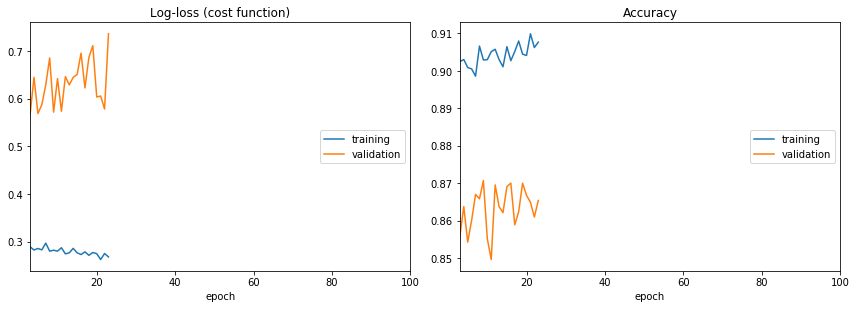

Log-loss (cost function):
training   (min:    0.262, max:    0.297, cur:    0.268)
validation (min:    0.566, max:    0.736, cur:    0.736)

Accuracy:
training   (min:    0.899, max:    0.910, cur:    0.908)
validation (min:    0.850, max:    0.871, cur:    0.865)
25890/25890 [==============================] - 393s 15ms/sample - loss: 0.2678 - acc: 0.9076 - val_loss: 0.7360 - val_acc: 0.8654
Epoch 00083: early stopping
Saved model_1.h5



In [0]:

from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from livelossplot import PlotLossesKeras
%matplotlib inline

def create_model(numClasses):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Conv2D(100, kernel_size=(12,12),
              activation='relu',input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(50, (6, 6), padding="SAME", activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Conv2D(20, (5, 5), padding="SAME", activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.8))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(numClasses, activation='softmax'))
  
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
              #optimizer=tf.keras.optimizers.Adadelta(lr=1.0),
              #optimizer=tf.keras.optimizers.SGD(lr=0.00052),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
    
    return model


model = create_model(numClasses)
model.summary()


es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=20)

# include the epoch in the file name. (uses `str.format`)
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/cp_short-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',mode='min', verbose=1, save_best_only=False)

csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/training1_short.log', append=True, separator=',')
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss',mode='min', verbose=1, save_best_only=True)

batch_size = 16
epochs = 100

#history = model.fit(X_train, y_train,
#                    batch_size=batch_size,
#                    epochs=epochs,
#                    verbose=1,
#                    shuffle=True,
#                    validation_data=(X_valid, y_valid), callbacks=[es, cp_callback, csv_logger, PlotLossesKeras()])

model.load_weights("/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/cp_short-0060.ckpt")
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    initial_epoch = 60,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_valid, y_valid), callbacks=[es, cp_callback, csv_logger, PlotLossesKeras()])                    
    
model.save("/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/model_1_1_short.h5")
print("Saved model_1.h5\n")

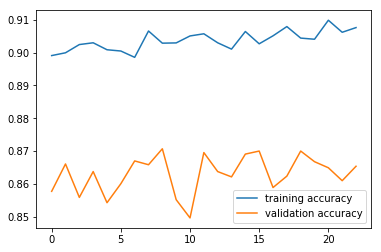

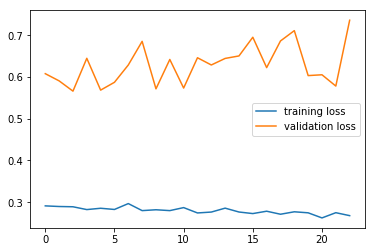

In [0]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
valid_loss, valid_acc = model.evaluate(X_valid, y_valid, verbose=0)

import matplotlib.pyplot as plt

val_acc = history.history['val_acc']
acc = history.history['acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
np.savez("/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/val_acc_1_short.npz",loss=loss, acc=acc, val_loss=val_loss, val_acc=val_acc)

epoch_num = np.arange(0, len(val_acc), dtype=int)

plot1, = plt.plot(epoch_num, acc)
plot2, = plt.plot(epoch_num, val_acc)
plt.legend([plot1, plot2],['training accuracy', 'validation accuracy'])
plt.show()

plot1, = plt.plot(epoch_num, loss)
plot2, = plt.plot(epoch_num, val_loss)
plt.legend([plot1, plot2],['training loss', 'validation loss'])
plt.show()

In [0]:
import requests

def telegram(message):

    bot_token = '923260274:AAHyCqG6jpPI_xo0x2wJvhGVA_oeUnMf41Y'
    bot_chatID = '763781536'
    send = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + message
    try:
        response = requests.get(send)
        response.raise_for_status()
    except requests.exceptions.RequestException as err:
        print ("OOps: Something Else",err)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)  
    return response.json()



message = "cnn for reinforcement\n" + "test_loss :" + str(test_loss) + "\n" + "test_acc :" + str(test_acc)  + "\n" + "valid_loss :" + str(valid_loss) + "\n" + "valid_acc :" + str(valid_acc) + "\n" + "train_loss :" + str(train_loss) + "\n" + "train_acc :" + str(train_acc) 
telegram(message)

{'ok': True,
 'result': {'chat': {'first_name': 'Shalom',
   'id': 763781536,
   'type': 'private',
   'username': 'NeeNoKi'},
  'date': 1569986695,
  'entities': [{'length': 28, 'offset': 26, 'type': 'italic'},
   {'length': 30, 'offset': 73, 'type': 'italic'},
   {'length': 31, 'offset': 123, 'type': 'italic'}],
  'from': {'first_name': 'NeeNo',
   'id': 923260274,
   'is_bot': True,
   'username': 'NeeNoKibot'},
  'message_id': 136,
  'text': 'cnn for reinforcement\ntestloss :1.268582045246317\ntestacc :0.814832\nvalidloss :0.7359917687668723\nvalidacc :0.8653534\ntrainloss :0.16990707181604076\ntrainacc :0.9518733'}}

In [0]:
#model = create_model2()
model.save_weights("/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/model_1_shortweights.h5")
model_json = model.to_json()
with open("/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/model_1_shortarchitecture.json", "w") as json_file:
    json_file.write(model_json)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


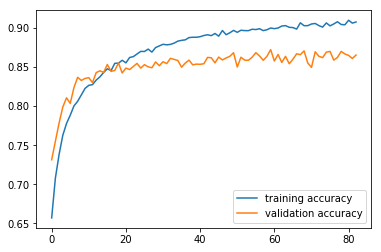

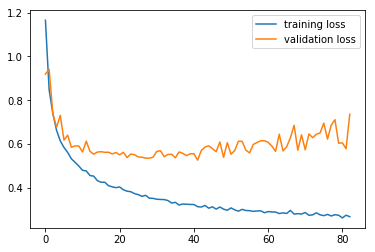

In [0]:

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

epoch = []
acc = []
loss = []
val_acc = []
val_loss = []
count = 0

with open('/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/training1_short.log') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
      if (count==0): 
        count += 1
        continue
        
      # epoch,acc,loss,val_acc,val_loss
      epoch.append(int(row[0]))
      acc.append(float(row[1]))
      loss.append(float(row[2]))
      val_acc.append(float(row[3]))
      val_loss.append(float(row[4]))

plot1, = plt.plot(epoch, acc)
plot2, = plt.plot(epoch, val_acc)
plt.legend([plot1, plot2],['training accuracy', 'validation accuracy'])
plt.show()

plot1, = plt.plot(epoch, loss)
plot2, = plt.plot(epoch, val_loss)
plt.legend([plot1, plot2],['training loss', 'validation loss'])
plt.show()
